## 1. Importing Libraries

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score


## 2. Necessary Functions

In [36]:
def scale_features(feature, scaler_type='standard'):
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError(" Opt either 'standard' or 'minmax'.")
    
    # Identify columns to scale (exclude one-hot encoded columns)
    
    cols_numerics = feature.select_dtypes(include=['int64', 'float64']).columns
    feature_scaled = feature.copy()
    feature_scaled[cols_numerics] = scaler.fit_transform(feature[cols_numerics])
    return feature_scaled

# def accuracy_calculate(X, y):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     clf = LogisticRegression(random_state=42)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     return accuracy

def evaluate_model(y_true, y_pred, y_prob):
    # If y_prob is 2D, take the second column (probabilities for positive class)
    if y_prob.ndim == 2:
        y_prob = y_prob[:, 1]
    
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Sensitivity': recall_score(y_true, y_pred),
        'Specificity': recall_score(y_true, y_pred, pos_label=0),
        'Precision': precision_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'AUROC': roc_auc_score(y_true, y_prob),
        'AUPR': average_precision_score(y_true, y_prob)
    }




## 3. Data Preprocessing of the Telco Customer Churn Dataset

In [37]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
# df.shape
# df.isnull().sum()
# df.describe()
# df.duplicated().sum()

df[df.duplicated(keep=False)]
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
df.drop_duplicates(inplace=True)
df.dropna(subset=['Churn'], inplace=True)
#drop customerID and create featues
Features = df.drop(['customerID', 'Churn'], axis=1)
label_Telco = df['Churn']

# Features.shape
# label_Telco.shape
label_Telco = label_Telco.map({'Yes':1, 'No':0})

# print(Features.dtypes)

# Process column 'TotalCharges' to numeric
Features['TotalCharges'] = pd.to_numeric(Features['TotalCharges'], errors='coerce')

# replace missing values with mean
Features['TotalCharges'] = Features['TotalCharges'].fillna(Features['TotalCharges'].mean()) 

# print(Features.dtypes)

categorical_columns = Features.select_dtypes(include=['object']).columns

for col in categorical_columns:
    Features[col] = Features[col].astype('category')

for column in categorical_columns:
    Features = pd.get_dummies(Features, columns=[column])

# scaling the features
Features_scaled = scale_features(Features, 'standard')
# Features_scaled.head()

features_df = pd.DataFrame(Features_scaled, columns=Features.columns) # scaled feature dataframe
target_df = pd.DataFrame(label_Telco, columns=['Churn']) # target dataframe

target_series = target_df['Churn'] # target series
correlationMatrix = features_df.corrwith(target_series)
# correlationMatrix

top_k_corr = correlationMatrix.abs().nlargest(20)
# top_k_corr

Features_Telco_TopK = Features_scaled[top_k_corr.index]

# use only top k features 

# accuracy = accuracy_calculate(Features_Telco_TopK, label_Telco)

# print(f"Accuracy with LogisticRegression Library : {accuracy:.6f}")  


## 4. Data Preprocessing of the Credit Card Dataset

In [38]:
df = pd.read_csv('creditcard.csv')
# randomly select 20000 negative samples + all positive samples
df_positive = df[df['Class'] == 1]
df_negative = df[df['Class'] == 0].sample(n=20000, random_state=42)

df = pd.concat([df_positive, df_negative], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle the data
# df

# df.isnull().sum()
# df.duplicated().sum()
# df[df.duplicated(keep=False)] 
# print(df)
df.drop_duplicates(inplace=True)
# print(df)
df.dropna(subset=['Class'], inplace=True)

label_CreditCard = df['Class']
Features = df.drop(columns=['Class'], axis=1)
#count missing values in each column
# missing = Features.isnull().sum()
# print(missing)
# replace missing values with mean
Features.fillna(Features.mean(), inplace=True)
# categorical_columns = Features.select_dtypes(include=['object']).columns
# categorical_columns.size
# for col in categorical_columns:
#     Features[col] = Features[col].astype('category')

# for column in categorical_columns:
#     Features = pd.get_dummies(Features, columns=[column])


# scaling the features
Features_scaled = scale_features(Features, 'standard')
features_df = pd.DataFrame(Features_scaled, columns=Features.columns) # scaled feature dataframe
label_df = pd.DataFrame(label_CreditCard, columns=['Class']) # label dataframe

target_series = label_df['Class'] 
correlationMatrix = features_df.corrwith(target_series)

top_k_corr = correlationMatrix.abs().nlargest(15)
# top_k_corr

Features_CreditCard_TopK = Features_scaled[top_k_corr.index]

# accuracy = accuracy_calculate(Features_CreditCard_TopK, label_CreditCard)
# print(f"Accuracy with LogisticRegression Library : {accuracy:.6f}")  



## 5. Data Preprocessing of the Adult Dataset

In [39]:
df = pd.read_csv('adult/adult.data', header=None)
# df
test = pd.read_csv('adult/adult.test', header=None, skiprows=1)
# test
df = pd.concat([df, test], ignore_index=True)

#duplicate count
# df.duplicated().sum()

df.replace(' ?', np.nan, inplace=True)
df.replace(' <=50K.', ' <=50K', inplace=True)
df.replace(' >50K.', ' >50K', inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(subset = [14], inplace=True)
# df

label_adult = df[14]
Features_adult = df.drop(columns=[14], axis=1)
# Features_adult
#unique value count in label
# label_adult.value_counts()
label_adult = label_adult.map({' <=50K': 0, ' >50K': 1})
# label_adult.value_counts()

Features_adult.dtypes
# Fill missing values with the mode for categorical columns and mean for numerical columns
# catNa=0 
# numNa=0 
# print(Features_adult.isnull().sum())
for col in Features_adult.columns:
    if Features_adult[col].dtype == 'object':
        # catNa+=1
        Features_adult[col] = Features_adult[col].fillna(Features_adult[col].mode()[0])
    else:
        # numNa+=1
        Features_adult[col] = Features_adult[col].fillna(Features_adult[col].mean())


# Features_adult.isnull().sum()
# Features_adult.shape
print(Features_adult.shape)
categorical_columns = Features_adult.select_dtypes(include=['object']).columns
categorical_columns.size
for col in categorical_columns:
    Features_adult[col] = Features_adult[col].astype('category')

for column in categorical_columns:
    Features_adult = pd.get_dummies(Features_adult, columns=[column])

Features_adult.shape
# Features_adult


# scaling the features
Features_scaled = scale_features(Features_adult, 'standard')
features_df = pd.DataFrame(Features_scaled, columns=Features_adult.columns) # scaled feature dataframe
label_df = pd.DataFrame(label_adult, columns=[14]) # label dataframe

target_series = label_df[14] 
correlationMatrix = features_df.corrwith(target_series)

top_k_corr = correlationMatrix.abs().nlargest(25)
# top_k_corr

Features_adult_TopK = Features_scaled[top_k_corr.index]


Features_adult_TopK.columns = Features_adult_TopK.columns.astype(str)

# use only top k features 

# accuracy = accuracy_calculate(Features_adult_TopK, label_adult)

# print(f"Accuracy with LogisticRegression Library : {accuracy:.6f}")  

(48790, 14)


## 6. Split the data into training, validation and testing sets

In [40]:
# Uncomment Features_adult_TopK and label_adult for adult dataset
# Uncomment Features_CreditCard_TopK and label_CreditCard for creditcard dataset 
# Uncomment Features_Telco_TopK and label_Telco for Telco dataset

# Features_top_k_Scaled = Features_Telco_TopK
# label = label_Telco

Features_top_k_Scaled = Features_CreditCard_TopK
label = label_CreditCard

# Features_top_k_Scaled = Features_adult_TopK 
# label = label_adult

X_train, X_test, y_train, y_test = train_test_split(Features_top_k_Scaled, label, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 7. Logistic Regression Implementation:



In [41]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class LogisticRegressionSelf(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, num_iterations=1000, regularization='l2', lambda_param=0.1):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.regularization = regularization
        self.lambda_param = lambda_param
        self.weights = np.array([])  # Initialize as numpy array
        self.bias = np.array(0)      # Initialize as numpy array

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        # Initialize parameters
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Gradient descent
        for _ in range(self.num_iterations):
            # Forward pass
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(z)

            # Compute gradients
            dw = (1 / X.shape[0]) * np.dot(X.T, (y_pred - y))
            db = (1 / X.shape[0]) * np.sum(y_pred - y)

            # Add regularization if specified
            if self.regularization == 'l2':
                dw += (self.lambda_param / X.shape[0]) * self.weights
            elif self.regularization == 'l1':
                dw += (self.lambda_param / X.shape[0]) * np.sign(self.weights)

            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        return (y_pred >= 0.5).astype(int)

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float64)        
        z = np.dot(X, self.weights) + self.bias 
        proba_1 = self.sigmoid(z)
        return np.column_stack([1 - proba_1, proba_1])

## 8. Bagging Implementation:

In [42]:
import numpy as np
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class BaggingEnsemble(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, n_estimators=9):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        self.models = []
        for _ in range(self.n_estimators):
            # Sample with replacement
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]
            
            # Train a new model on the sample
            model = clone(self.base_model)
            model.fit(X_sample, y_sample)
            self.models.append(model)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        predictions = np.array([model.predict(X) for model in self.models])
        return np.round(np.mean(predictions, axis=0)).astype(int)

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float64)                
        probas = np.array([model.predict_proba(X)[:, 1] for model in self.models])
        return np.mean(probas, axis=0)

# 9. Stacking Implementation:

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class StackingEnsemble(BaseEstimator, ClassifierMixin):
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
        self.trained_base_models = None

    def fit(self, X, y):
        
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)

        # Train base models on the training data
        self.trained_base_models = []
        for model in self.base_models:
            cloned_model = clone(model)
            cloned_model.fit(X_train, y_train)
            self.trained_base_models.append(cloned_model)

        # Generate meta-features using the validation set
        meta_features = self._get_meta_features(X_val)

        # Train the meta-model on the meta-features
        self.meta_model.fit(meta_features, y_val)

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float64)
        meta_features = self._get_meta_features(X)
        return self.meta_model.predict(meta_features)

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float64)
        meta_features = self._get_meta_features(X)
        return self.meta_model.predict_proba(meta_features)

    def _get_meta_features(self, X):
        X = np.asarray(X, dtype=np.float64)
        if self.trained_base_models is None:
            raise ValueError("Base models have not been trained. Call fit() before predict_proba().")
        meta_features = np.column_stack([
            model.predict_proba(X)[:, 1] for model in self.trained_base_models
        ])
        return np.column_stack([X, meta_features])  # Add original features


# 10. Execution

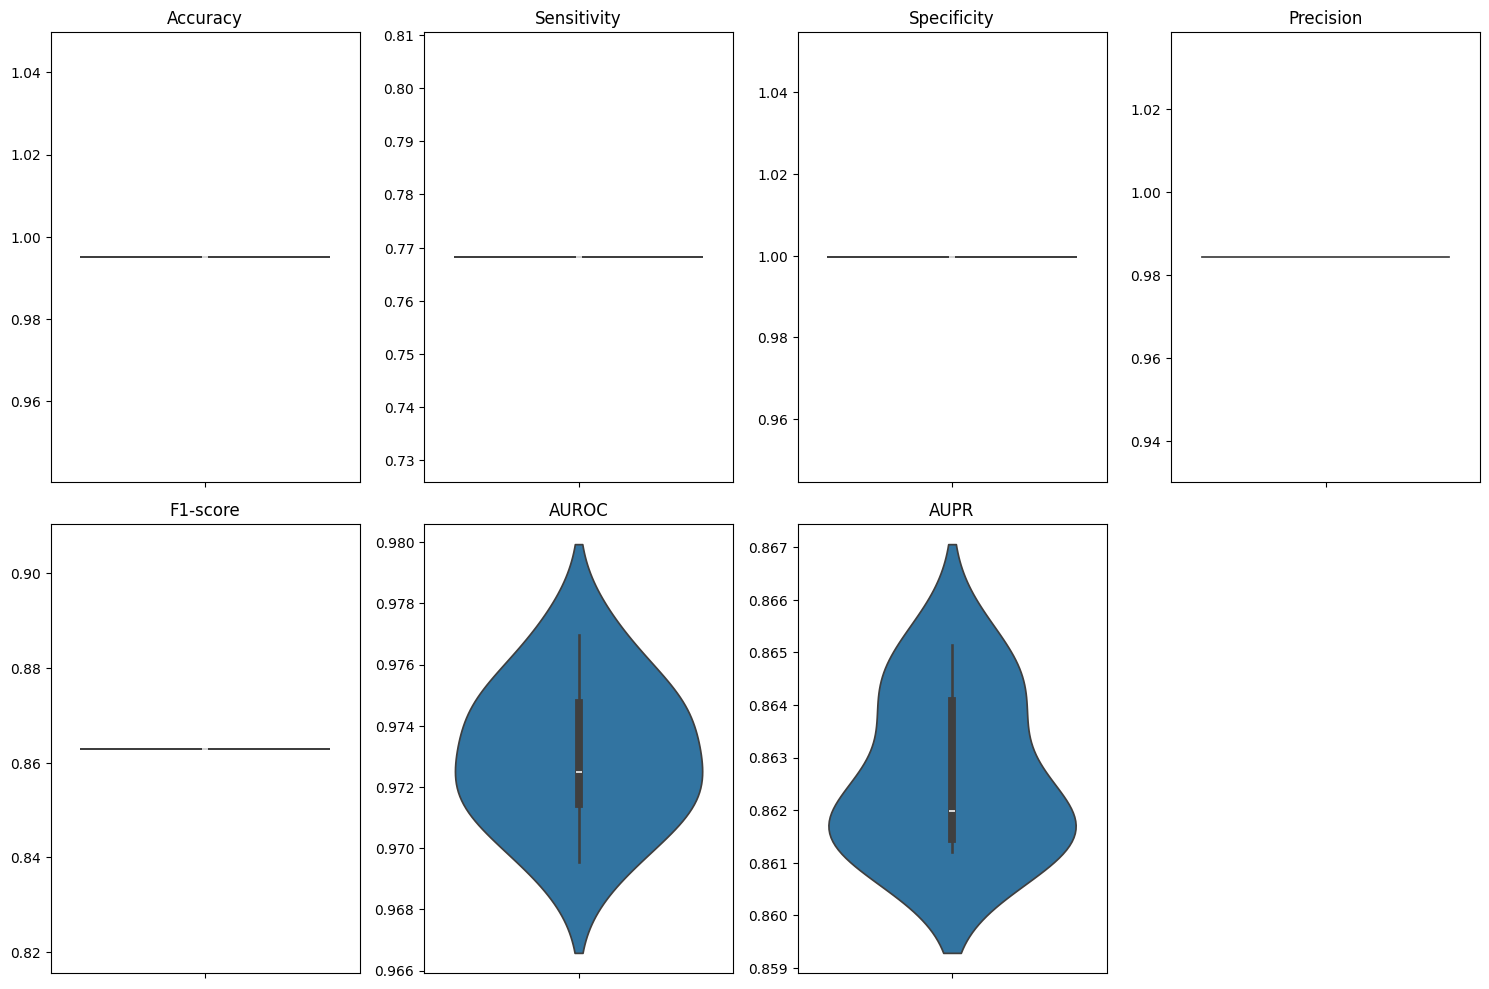

            LR (avg ± std) Voting Ensemble Stacking Ensemble
Accuracy     0.995 ± 0.000           0.995             0.995
Sensitivity  0.768 ± 0.000           0.768             0.768
Specificity  1.000 ± 0.000           1.000             1.000
Precision    0.984 ± 0.000           0.984             0.984
F1-score     0.863 ± 0.000           0.863             0.863
AUROC        0.973 ± 0.002           0.974             0.964
AUPR         0.863 ± 0.001           0.864             0.860


In [44]:
# Train individual LR models with bagging
logistic_regression_instance = LogisticRegressionSelf()
bagging_ensemble = BaggingEnsemble(logistic_regression_instance, n_estimators=9)
bagging_ensemble.fit(X_train, y_train)

# Train stacking ensemble
base_models = [LogisticRegressionSelf() for _ in range(9)]
stacking_ensemble = StackingEnsemble(base_models, LogisticRegressionSelf())
stacking_ensemble.fit(X_train, y_train)

# Evaluate models


results = []
for i, model in enumerate(bagging_ensemble.models):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    results.append(evaluate_model(y_test, y_pred, y_prob))

# Evaluate ensembles
y_pred_voting = bagging_ensemble.predict(X_test)
y_prob_voting = bagging_ensemble.predict_proba(X_test)
results.append(evaluate_model(y_test, y_pred_voting, y_prob_voting))

y_pred_stacking = stacking_ensemble.predict(X_test)
y_prob_stacking = stacking_ensemble.predict_proba(X_test)
results.append(evaluate_model(y_test, y_pred_stacking, y_prob_stacking))

# Create violin plots
metrics = list(results[0].keys())
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 4, i+1)
    sns.violinplot(data=[r[metric] for r in results[:9]])
    plt.title(metric)
plt.tight_layout()
plt.show()

# Create comparison table
model_names = ['LR (avg ± std)'] + ['Voting Ensemble', 'Stacking Ensemble']
table_data = []

for metric in metrics:
    lr_values = [r[metric] for r in results[:9]]
    lr_avg = np.mean(lr_values)
    lr_std = np.std(lr_values)
    voting_value = results[-2][metric]
    stacking_value = results[-1][metric]
    table_data.append([f'{lr_avg:.3f} ± {lr_std:.3f}', f'{voting_value:.3f}', f'{stacking_value:.3f}'])

table = pd.DataFrame(table_data, columns=model_names, index=metrics)
print(table)

## 11. Violin Plots

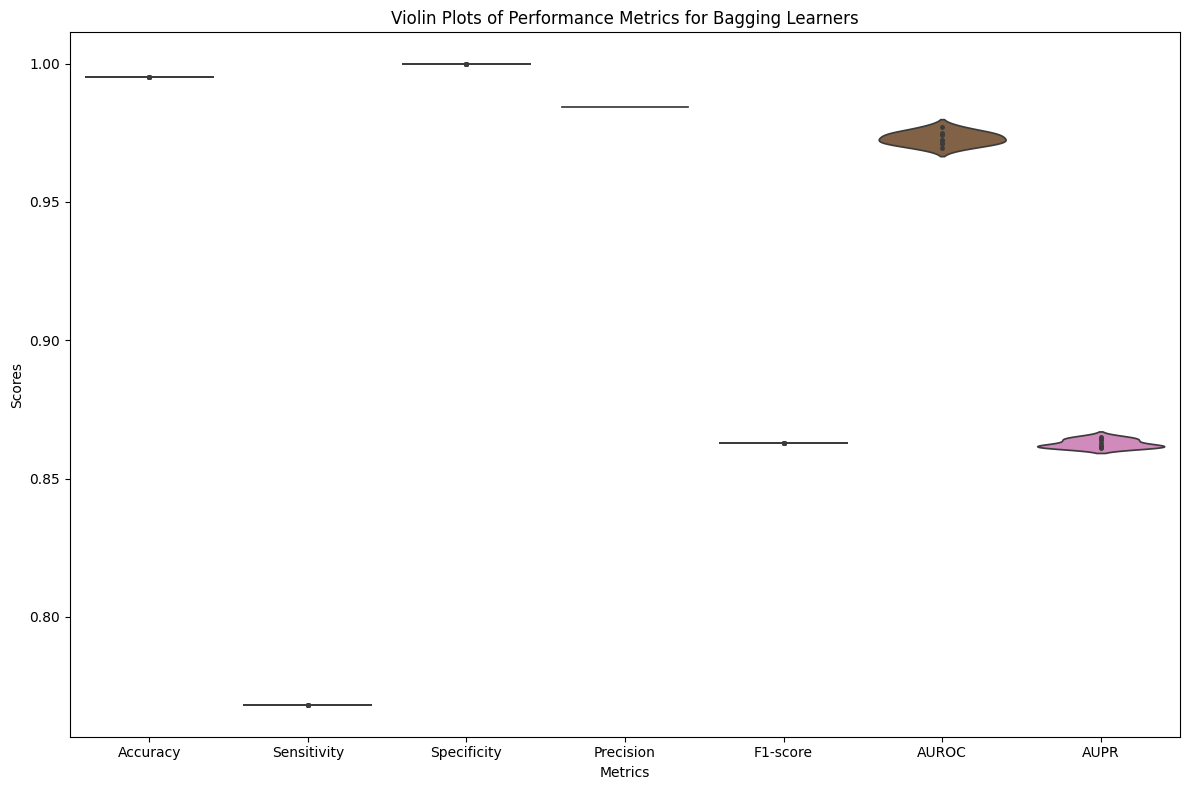

In [45]:

metrics = list(results[0].keys())  
learners = [f"Learner {i+1}" for i in range(9)]  

data = []
for i, result in enumerate(results[:9]): 
    for metric in metrics:
        data.append([learners[i], metric, result[metric]])

df = pd.DataFrame(data, columns=["Learner", "Metric", "Score"])

plt.figure(figsize=(12, 8))

sns.violinplot(x="Metric", y="Score", data=df, inner="point", palette="muted", hue ="Metric",  dodge=False, legend=False)

plt.title('Violin Plots of Performance Metrics for Bagging Learners')
plt.xlabel('Metrics')
plt.ylabel('Scores')

plt.tight_layout()
plt.show()
